In [1]:
# Setup environment
# !apt-get -qq install xxd
# !pip3 install pandas numpy matplotlib
# !pip3 install tensorflow==2.13.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import random

file_path = "processed_data/*"

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = "abcdefghijklmnopqrstuvwxyz"

SAMPLES_PER_GESTURE = 150

NUM_GESTURES = 26

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

datafiles = glob.glob(file_path)
# datafiles.sort()
print("total files", len(datafiles))

for datafile in datafiles:
    out = []    

    tensor = pd.read_csv(datafile)
    # inputs.append(np.array(tensor.values.ravel()))
    inputs.append(tensor)

    gesture_index=0
    for i in range(NUM_GESTURES):
        if datafile[15] == GESTURES[i]:
            gesture_index = i
    output = ONE_HOT_ENCODED_GESTURES[gesture_index]
    outputs.append(output)
    # print ("processed ", datafile, "output=", GESTURES[gesture_index])
    
print("total ", len(inputs))
# convert the list to numpy arra
inputs = np.array(inputs)
outputs = np.array(outputs)

print ("input shape: ", inputs.shape, " output shape", outputs.shape)

print("Data set parsing and preparation complete.")

2023-11-12 22:22:38.020227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version = 2.13.0

total files 7911
total  7911
input shape:  (7911, 150, 9)  output shape (7911, 26)
Data set parsing and preparation complete.


In [3]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [4]:
# # build the model and train it

model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (2,2), padding='same', strides=1, activation="relu",input_shape=(SAMPLES_PER_GESTURE, 9, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),

    tf.keras.layers.Conv2D(20, (2,2), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(26, activation="softmax")
]
)
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 9, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 4, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 4, 20)         2580      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 2, 20)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 37, 2, 20)         0         
                                                                 
 flatten (Flatten)           (None, 1480)              0

In [5]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=150, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/150
4746/4746 [==============================] - 16s 3ms/step - loss: 0.0359 - mae: 0.0718 - val_loss: 0.0347 - val_mae: 0.0702
Epoch 2/150
4746/4746 [==============================] - 21s 4ms/step - loss: 0.0287 - mae: 0.0584 - val_loss: 0.0134 - val_mae: 0.0320
Epoch 3/150
4746/4746 [==============================] - 19s 4ms/step - loss: 0.0123 - mae: 0.0247 - val_loss: 0.0064 - val_mae: 0.0149
Epoch 4/150
4746/4746 [==============================] - 20s 4ms/step - loss: 0.0075 - mae: 0.0145 - val_loss: 0.0047 - val_mae: 0.0086
Epoch 5/150
4746/4746 [==============================] - 20s 4ms/step - loss: 0.0056 - mae: 0.0106 - val_loss: 0.0036 - val_mae: 0.0064
Epoch 6/150
4746/4746 [==============================] - 20s 4ms/step - loss: 0.0046 - mae: 0.0084 - val_loss: 0.0024 - val_mae: 0.0046
Epoch 7/150
4746/4746 [==============================] - 20s 4ms/step - loss: 0.0038 - mae: 0.0070 - val_loss: 0.0020 - val_mae: 0.0033
Epoch 8/150
4746/4746 [=========================

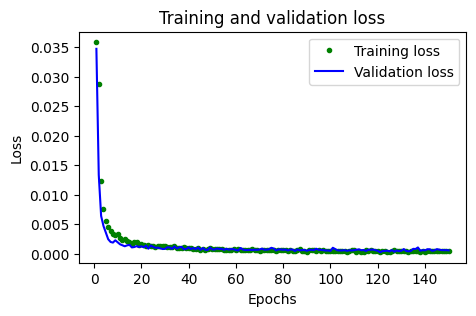

[5.0, 3.0]


In [6]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (5,3)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

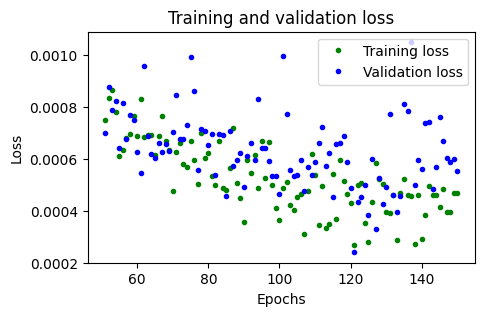

In [7]:
# graph the loss again skipping a bit of the start
SKIP = 50
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

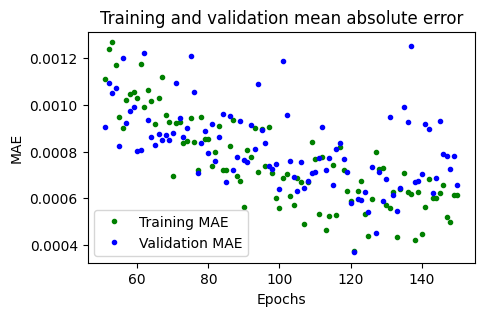

In [8]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [9]:
print("input shape" , inputs_test.shape)
print(type(inputs_test))
# print (len(data1))
# inputs_test = np.concatenate((inputs_test, [np.array(data1)]), axis=0)
# print("input shape" , inputs_test.shape)

input shape (1582, 150, 9)
<class 'numpy.ndarray'>


In [10]:
# t1 = pd.read_csv("processed_data/a_1.dat")
# print(t1)
# single_sample = np.array(t1.values.ravel())
# single_sample1 = (t1.melt().value.tolist())
# print(type(single_sample))
# prediction = model.predict(np.expand_dims(single_sample, axis=0))
# prediction1 = model.predict(np.expand_dims(single_sample1, axis=0))

# formatted_numbers = ["{:.2f}".format(number) for number in prediction[0]]

# print("Formatted Numbers:", formatted_numbers)
# print("Prediction:", prediction)
# prediction = model.predict([t1])
# print("predictions =\n", np.round(prediction, decimals=3))
# print(single_sample)
# print(single_sample1)

In [11]:
# t1 = pd.read_csv("processed_data/a_1.dat")
# [np.array(t1.values.ravel())]

# inputs_test = np.concatenate((inputs_test, [np.array(t1.values.ravel())]), axis=0)
# # 

In [12]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)
print("pred shape" , predictions.shape)
# predictions = model.predict(inputs_test[0].reshape(1,1248))
# print(predictions[0])
# print(outputs_test[0])
# print (inputs_test[0])

# pd.DataFrame(inputs_test[0]).to_csv("test1.h", sep=',', encoding='utf-8', index=False, header=False)
# !echo "const unsigned char tt[] = {" > ./tt.h
# !cat "test1.csv" | xxd -i      >> ./tt.h
# !echo "};"                              >> ./tt.h

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))

print("actual =\n", outputs_test)
a = np.round(predictions - outputs_test, decimals=0)
print(a)
# Plot the predictions along with to the test data
# plt.clf()
# plt.title('Training data predicted vs actual values')
# plt.plot( outputs_test, 'b.', label='Actual')
# plt.plot( predictions, 'r.', label='Predicted')
# plt.show()


50/50 [==============================] - 0s 4ms/step
pred shape (1582, 26)
predictions =
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
actual =
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
print(outputs_test[:, 0].dtype)
print(predictions[:, 0].dtype)

float64
float32


In [14]:
pre = (predictions + 0.5).astype(int)
# pre
a = pre-outputs_test
tests_by_letter = outputs_test.astype(bool).sum(axis=0)
print("tests by letter: ", tests_by_letter)
wrong_predict_by_letter = a.astype(bool).sum(axis=0)
print("wrong predict by letter: ", wrong_predict_by_letter)
print("wrong rate: ", np.round(wrong_predict_by_letter/tests_by_letter, decimals=2))

tests by letter:  [67 54 54 57 71 70 60 66 61 57 67 56 69 61 72 55 65 54 63 67 54 59 54 58
 56 55]
wrong predict by letter:  [0 3 0 0 0 1 2 2 2 1 0 2 3 1 0 1 1 2 1 2 0 2 0 1 1 0]
wrong rate:  [0.   0.06 0.   0.   0.   0.01 0.03 0.03 0.03 0.02 0.   0.04 0.04 0.02
 0.   0.02 0.02 0.04 0.02 0.03 0.   0.03 0.   0.02 0.02 0.  ]


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# accuracy = accuracy_score(outputs_test, predictions)
# precision = precision_score(outputs_test, predictions)
# recall = recall_score(outputs_test, predictions)
# f1 = f1_score(outputs_test, predictions)
# conf_matrix = confusion_matrix(outputs_test, predictions)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1-Score: {f1}")
# print(f"Confusion Matrix:\n{conf_matrix}")
# Initialize an array to store accuracy for each class

# class_accuracies = []

# # Iterate over each class (assuming axis 1 represents classes)
# for class_index in range(26):
#     true_labels_class = outputs_test[:, class_index]
#     predicted_labels_class = pre[:, class_index]
#     accuracy = accuracy_score(true_labels_class, predicted_labels_class)
#     class_accuracies.append(accuracy)

# # Calculate micro-average accuracy (overall accuracy)
# micro_average_accuracy = accuracy_score(outputs_test, predictions)

# # Calculate macro-average accuracy (average accuracy across classes)
# macro_average_accuracy = sum(class_accuracies) / len(class_accuracies)

# # Print individual class accuracies and the macro/micro averages
# for class_index, accuracy in enumerate(class_accuracies):
#     print(f"Class {class_index}: Accuracy = {accuracy}")

# print(f"Micro-average accuracy: {micro_average_accuracy}")
# print(f"Macro-average accuracy: {macro_average_accuracy}")
# In the code above:

# We iterate over each class, treating it as a binary classification problem by selecting the true labels and predicted labels for that class.
# We calculate the accuracy for each class separately and store it in the class_accuracies list.
# We compute the micro-average accuracy, which is the overall accuracy across all samples and classes.
# We compute the macro-average accuracy, which is the average accuracy across all classes.
# This approach allows you to evaluate the performance of your multi-class classification model for each individual class and provides overall accuracy metrics as well.







In [16]:
# import matplotlib.pyplot as plt

# plt.scatter(outputs_test, predictions)
# plt.xlabel("True Values")
# plt.ylabel("Predictions")
# plt.show()

from sklearn.metrics import r2_score


r2 = r2_score(outputs_test, predictions)
print("r2=", r2)

r2= 0.9828473250013835


In [17]:
outputs_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [18]:
(predictions[0]+0.5).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0])

In [19]:
# tf.saved_model.save(model, 'my_saved_model')

In [20]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmprr1v69d8/assets


INFO:tensorflow:Assets written to: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmprr1v69d8/assets


Model is 341864 bytes


2023-11-12 23:05:37.415662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-12 23:05:37.415681: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-12 23:05:37.416631: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmprr1v69d8
2023-11-12 23:05:37.419052: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-12 23:05:37.419069: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmprr1v69d8
2023-11-12 23:05:37.425030: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-11-12 23:05:37.427106: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-12 23:05:37.497324: I tensorflow/cc/saved_model/loader.

In [21]:
# Create a TensorFlow Lite interpreter for the converted model
# interpreter = tf.lite.Interpreter(model_content=tflite_model)
# interpreter.allocate_tensors()

# # Get the details of the TensorFlow Lite model
# ops_details = interpreter.get_tensor_details()

# # Print the details of each operator in the TensorFlow Lite model
# for op in ops_details:
#     print("Operator Name:", op['name'])
#     print("Operator Index:", op['index'])
#     print("Operator Shape:", op['shape'])
#     print("Operator Type:", op['dtype'])
#     print()

In [22]:
!echo "const unsigned char model[] = {" > ./content/model.h
!cat gesture_model.tflite | xxd -i      >> ./content/model.h
!echo "};"                              >> ./content/model.h

import os
model_h_size = os.path.getsize("./content/model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 2,108,196 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [23]:
from sklearn.metrics import f1_score

# Assuming 'y_true' contains the true labels and 'y_pred' contains the predicted labels
# f1 = f1_score(outputs_test, pre)

In [24]:


# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])